In [1]:
# データの読み込み
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# セッションの定義とか
import tensorflow as tf

session = tf.InteractiveSession()

x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])  # train

In [3]:
# 層定義用便利関数を定義
def weight_var(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_var(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def maxpool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

In [4]:
# 畳み込み層とかを定義
W_conv1 = weight_var([5, 5, 1, 32])  # 5x5, 1 channel, 32 output channel
b_conv1 = bias_var([32])

x_image = tf.reshape(x, [-1, 28, 28, 1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)  # [-1, 28, 28, 32]
h_pool1 = maxpool_2x2(h_conv1)  # [-1, 14, 14, 32]

W_conv2 = weight_var([5, 5, 32, 64])
b_conv2 = bias_var([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = maxpool_2x2(h_conv2)  # [-1, 7, 7, 64]

In [5]:
# Full-connectedの層を定義
W_fc1 = weight_var([7 * 7 * 64, 1024])
b_fc1 = bias_var([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [6]:
# Dropout
keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [7]:
# softmax
W_fc2 = weight_var([1024, 10])
b_fc2 = bias_var([10])
y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

In [8]:
# 学習のための定義
loss = -tf.reduce_sum(y_ * tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

correct = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

# 初期化
session.run(tf.initialize_all_variables())

In [9]:
for i in range(20000):
    batch_xs, batch_ys = mnist.train.next_batch(50)
    # 定期的に評価
    if not i % 200:
        score = accuracy.eval({x: mnist.test.images[:500], y_: mnist.test.labels[:500], keep_prob: 1.0})
        print(score)
        if score > 0.98:  # 日が暮れるので、0.98超えたら止める
            break
    train_step.run(feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})

0.084
0.904
0.944
0.948
0.966
0.962
0.97
0.974
0.976
0.98


accuracy: 0.972000
#bad images: 28 / 1000


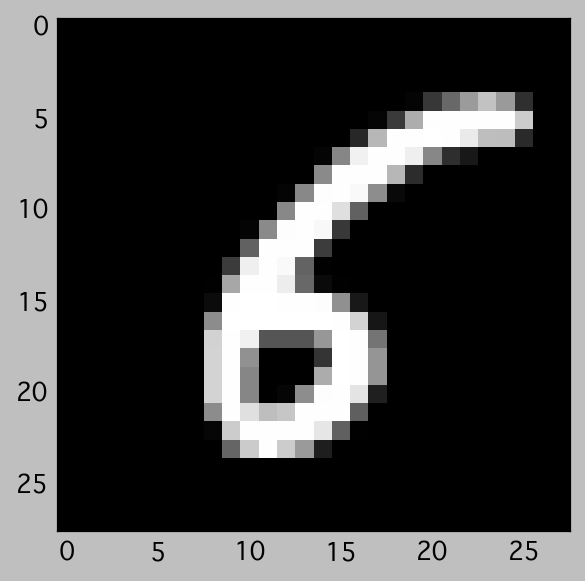

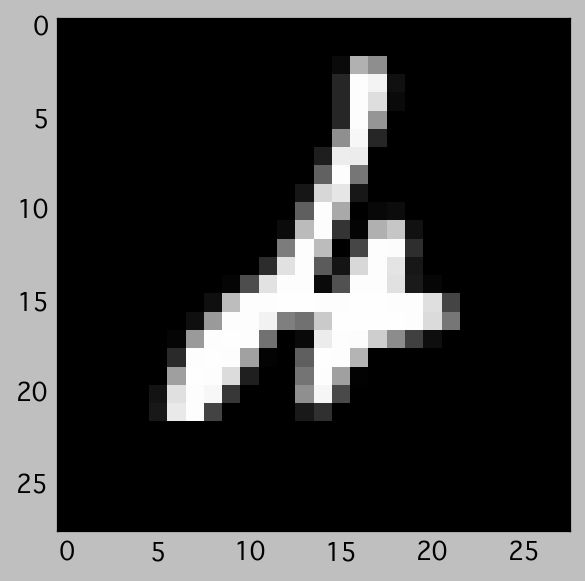

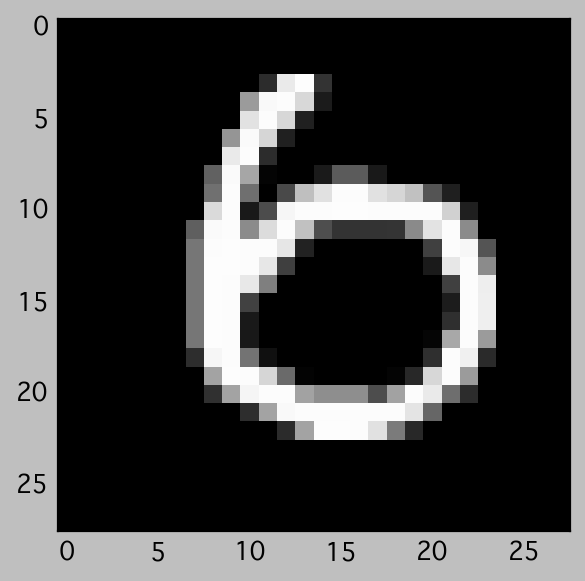

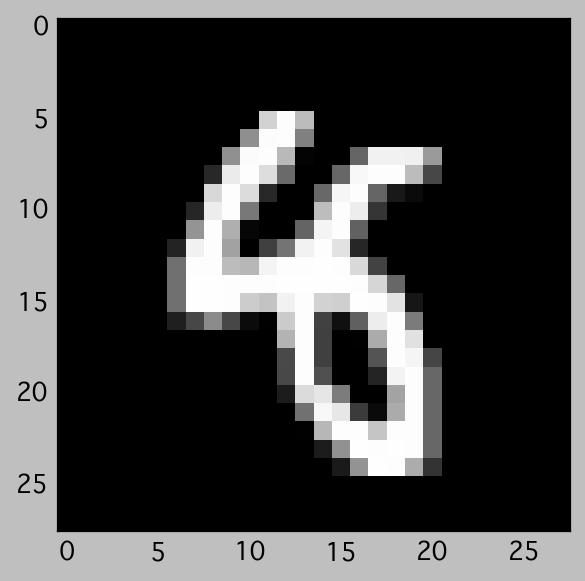

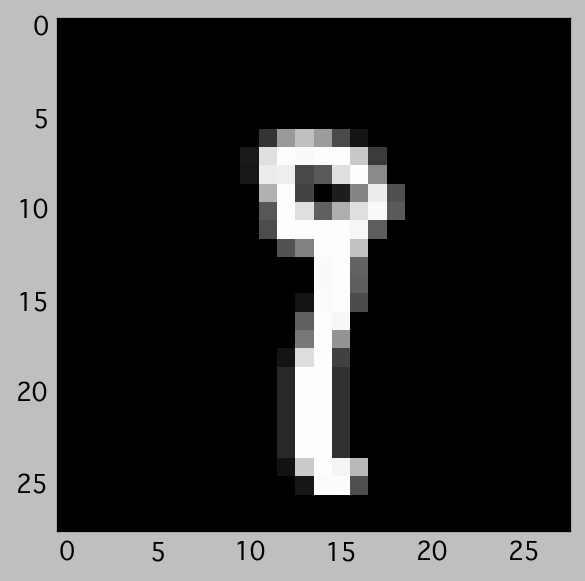

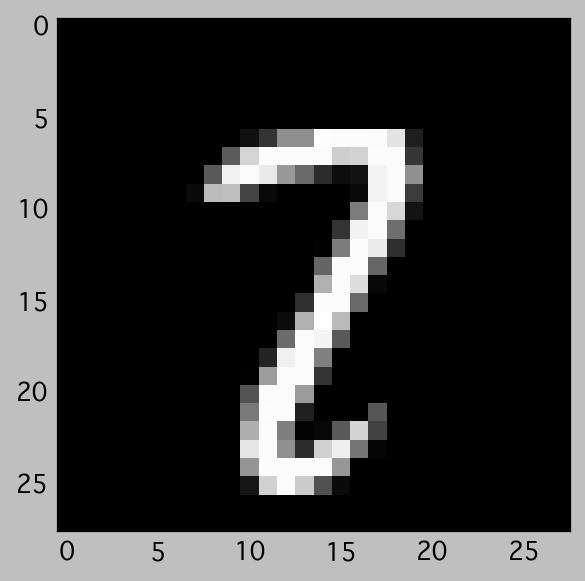

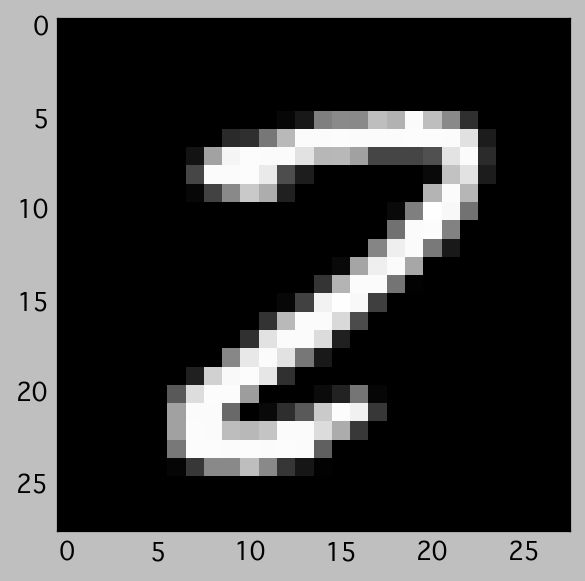

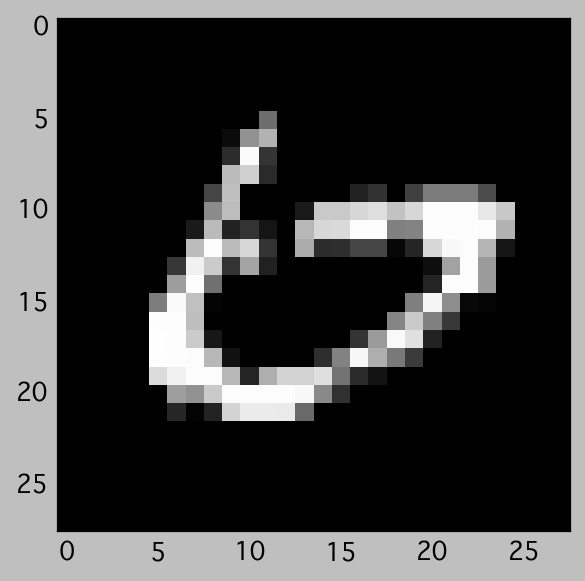

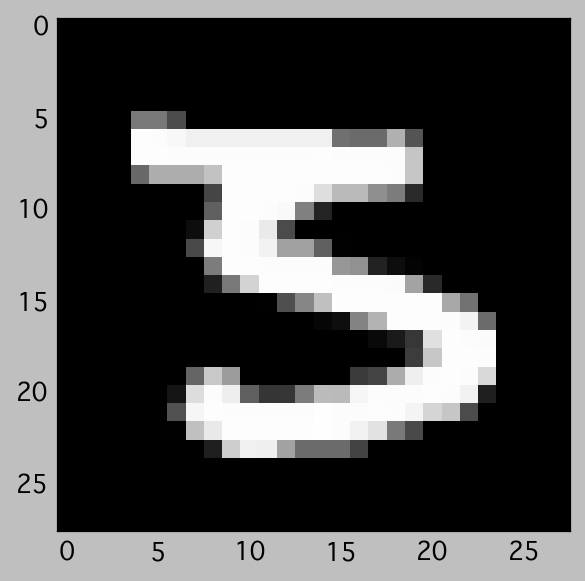

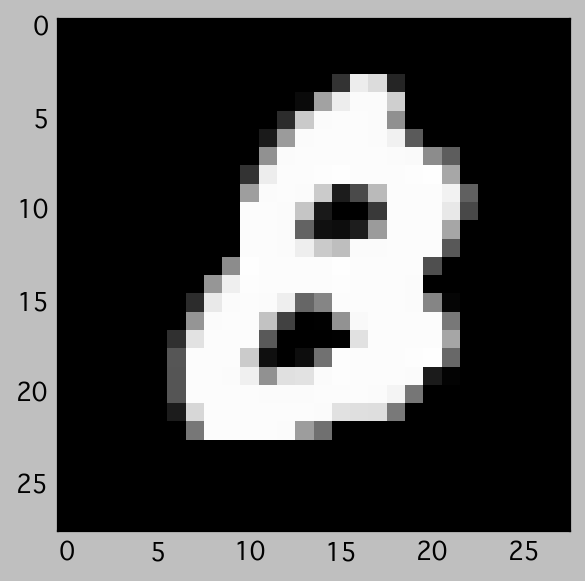

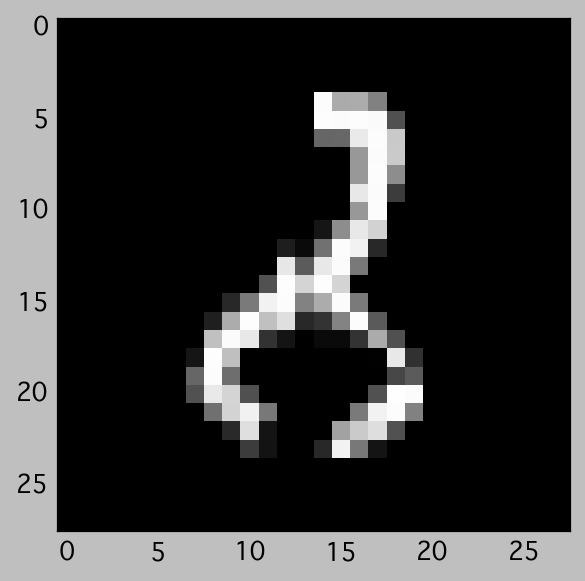

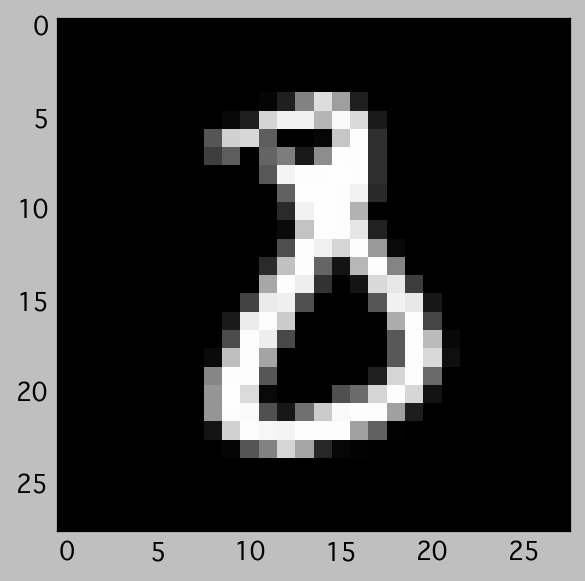

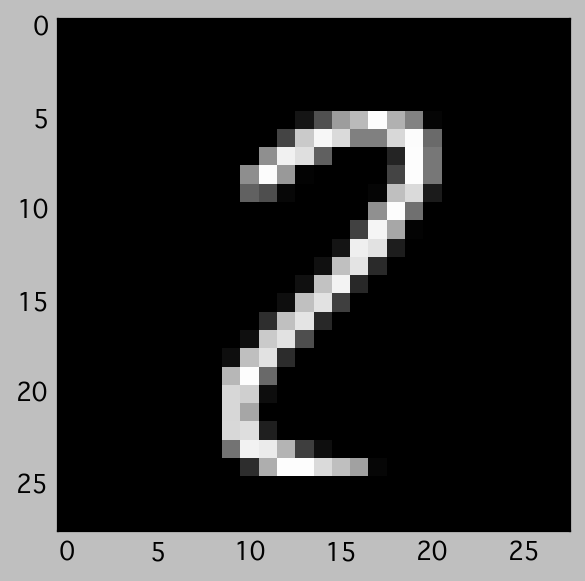

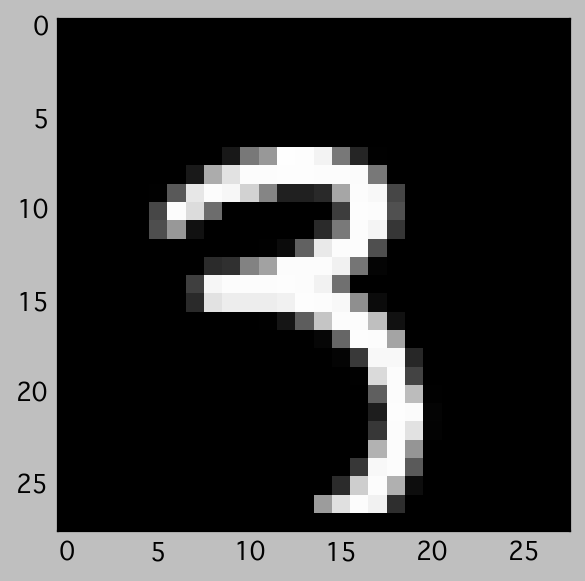

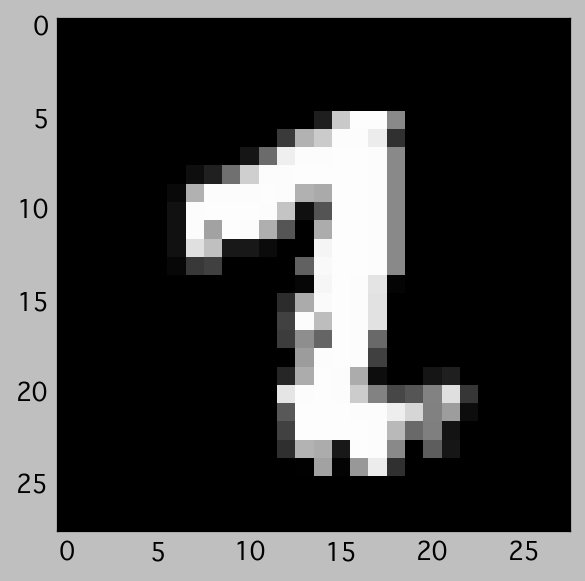

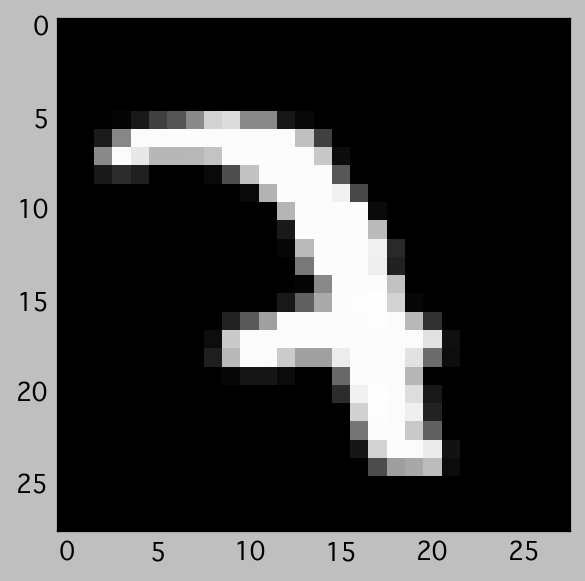

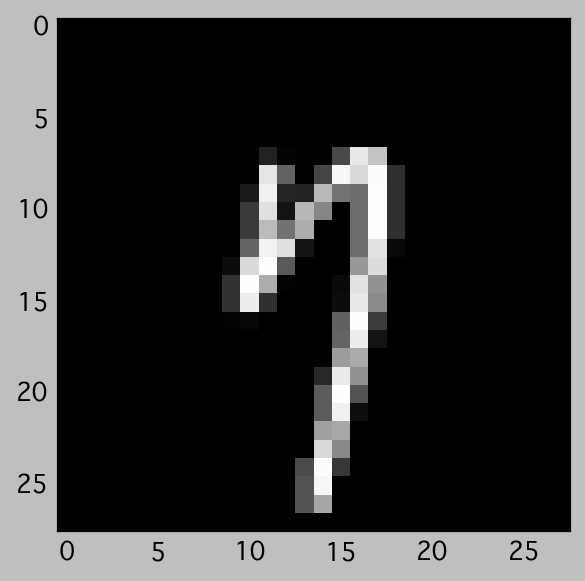

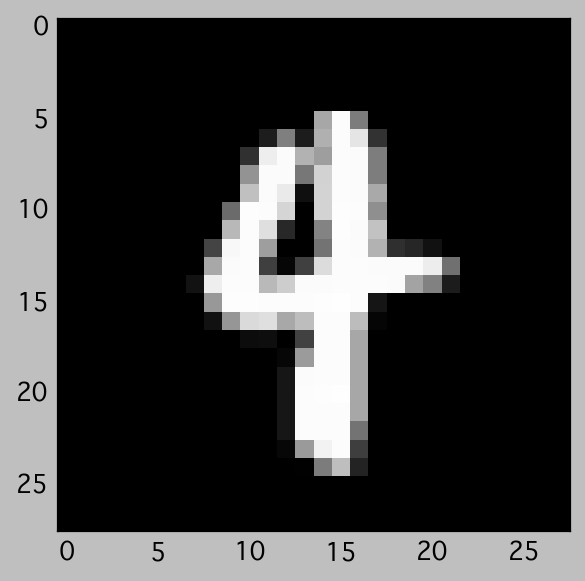

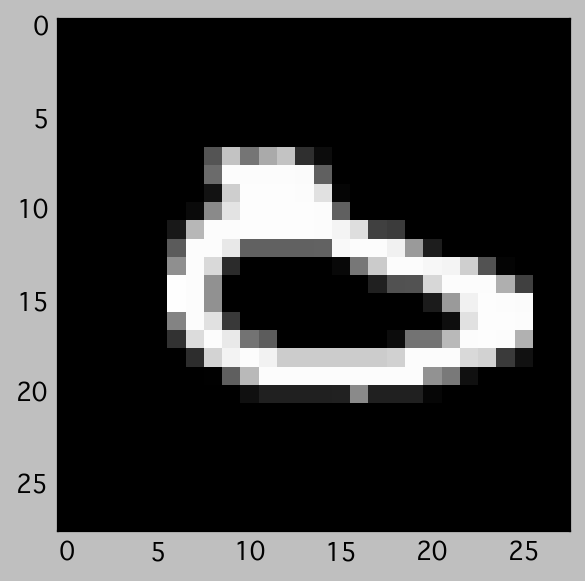

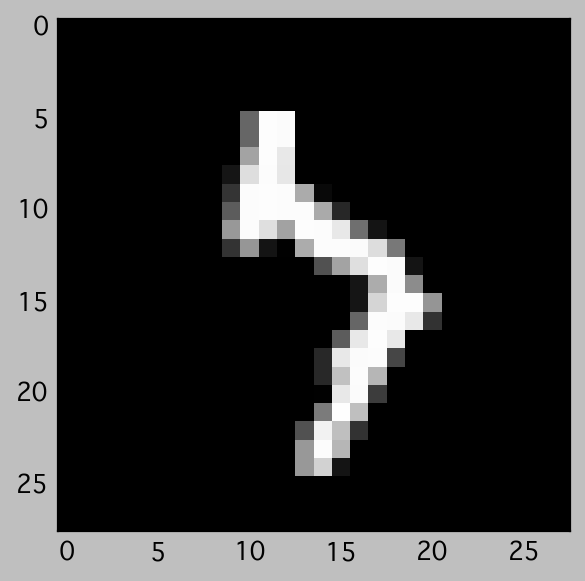

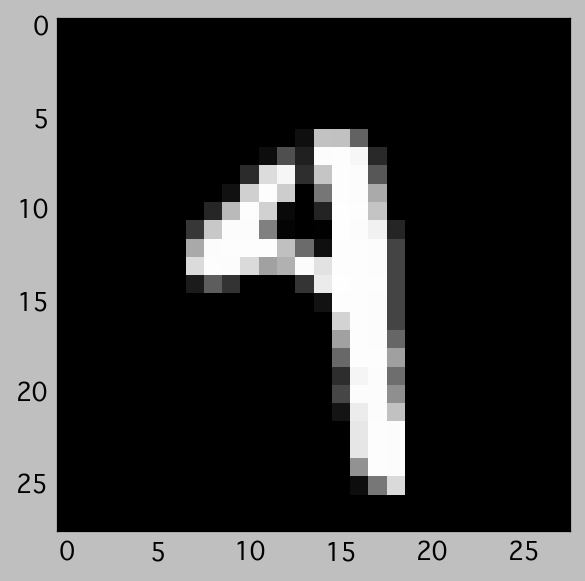

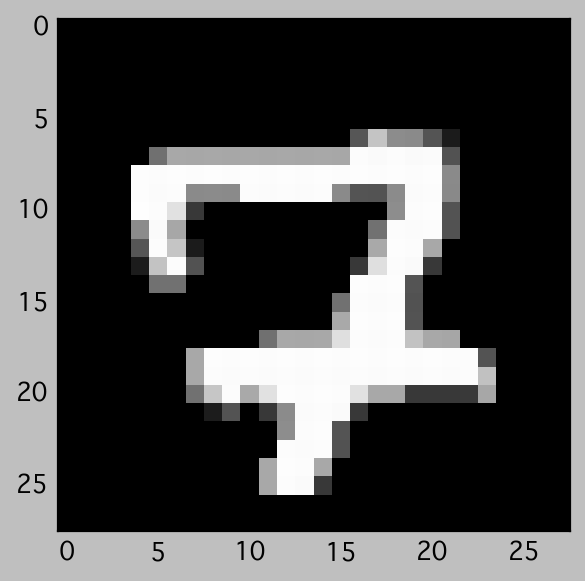

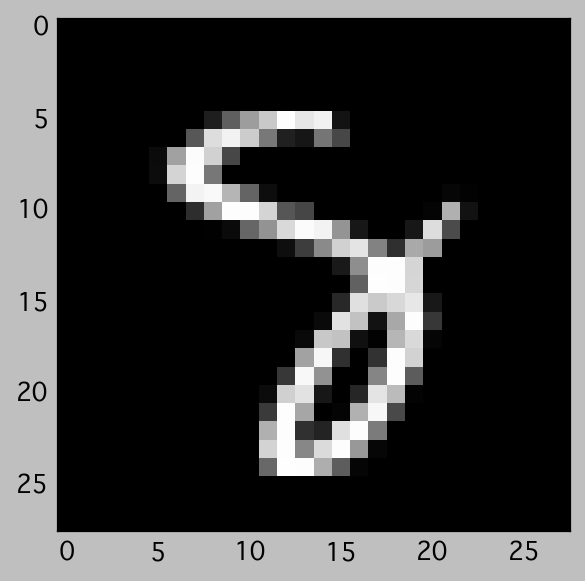

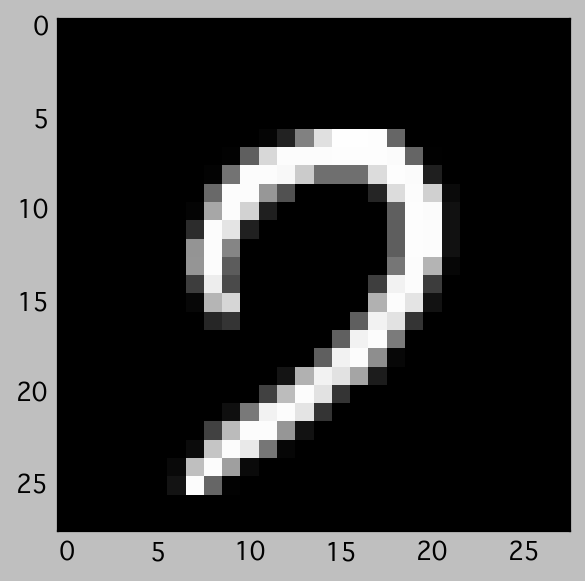

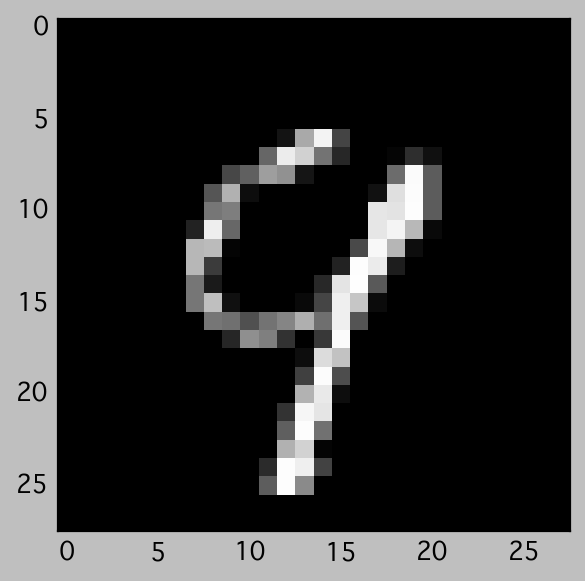

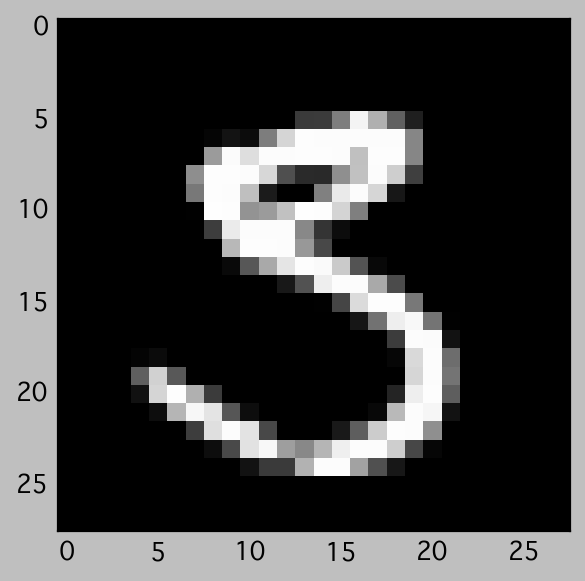

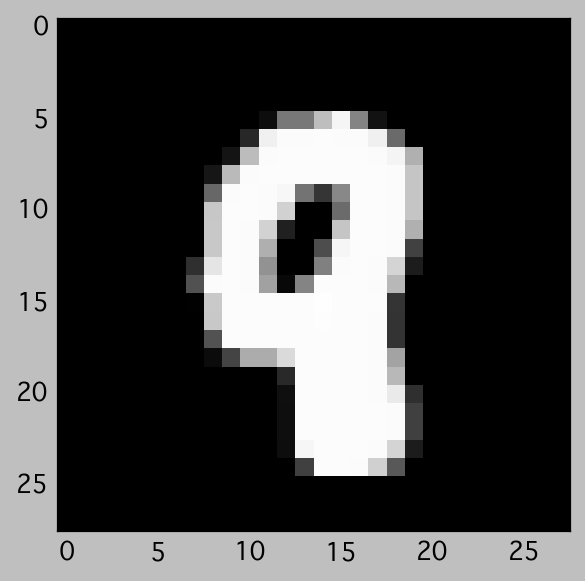

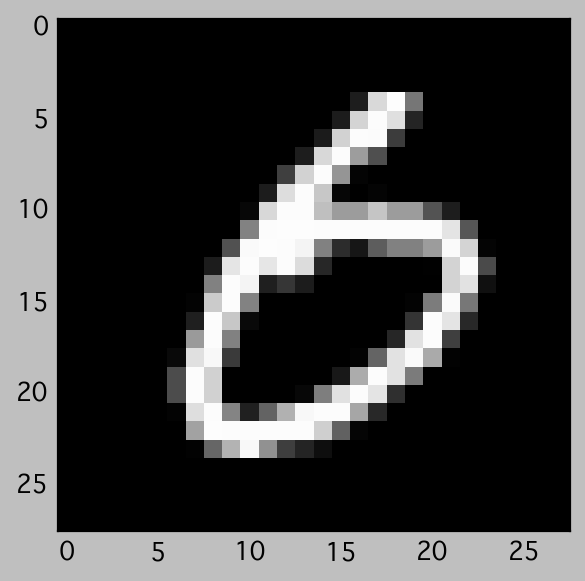

In [47]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt

def imshow(img):
    plt.imshow(img, interpolation='none', cmap='gray')

test_images = mnist.test.images[:1000]
test_labels = mnist.test.labels[:1000]

result = correct.eval({x: test_images, y_: test_labels, keep_prob: 1.0})
bad_imgs = test_images[~result]
for img in bad_imgs:
    plt.figure()
    imshow(img.reshape([28, 28]))

print('accuracy: %f' % (sum(result) / len(result)))
print('#bad images: %d / 1000' % (len(result) - sum(result)))

人間でも読めない数字もあるが、当てられそうな数字もある。

どうすれば読み取れるようになるか、どう改善していけばいいんだろう？

## 各層の効果の確認

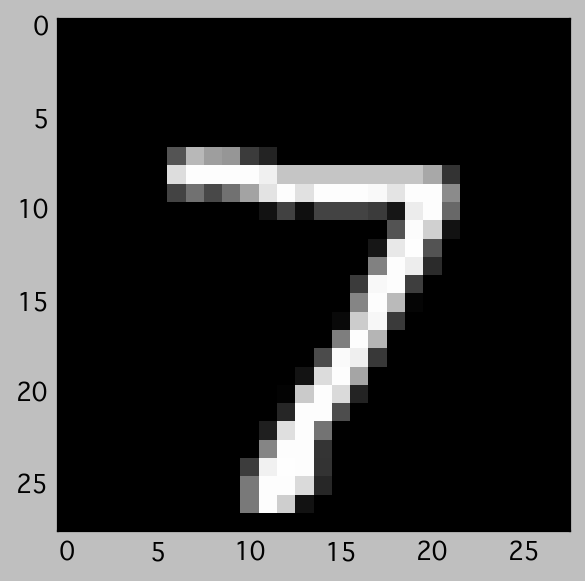

In [48]:
# 元の画像
def imshow(img):
    plt.imshow(img, interpolation='none', cmap='gray')
imshow(test_images[0].reshape([28, 28]))

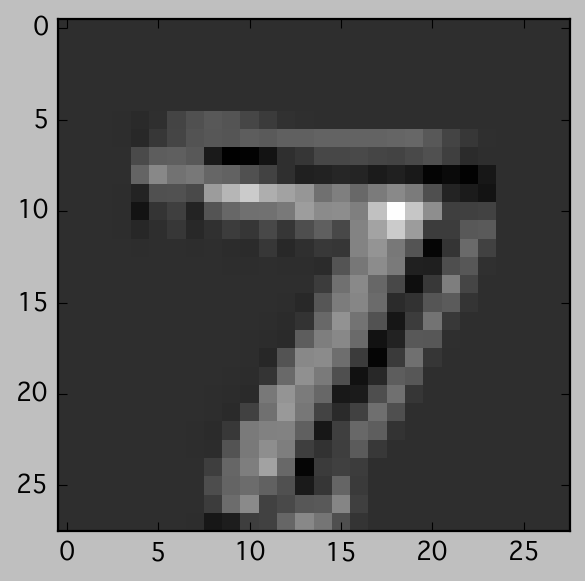

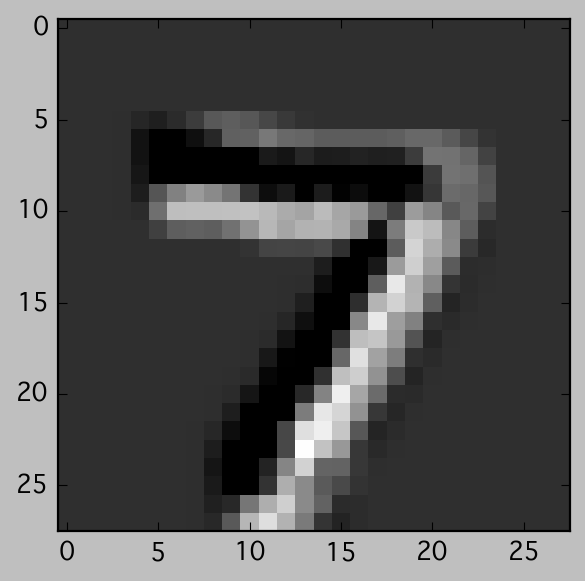

In [49]:
# 最初の畳み込み層
for i in range(2):
    plt.figure()
    imshow(h_conv1.eval({x: test_images[0:1], y_: test_labels[0:1]})[0][:, :, i])

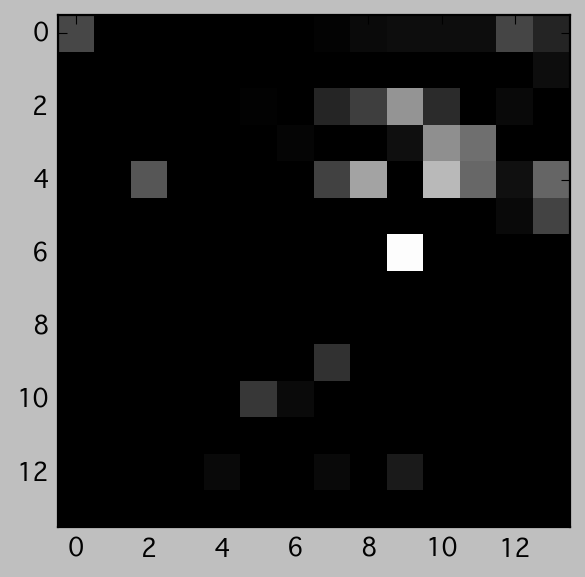

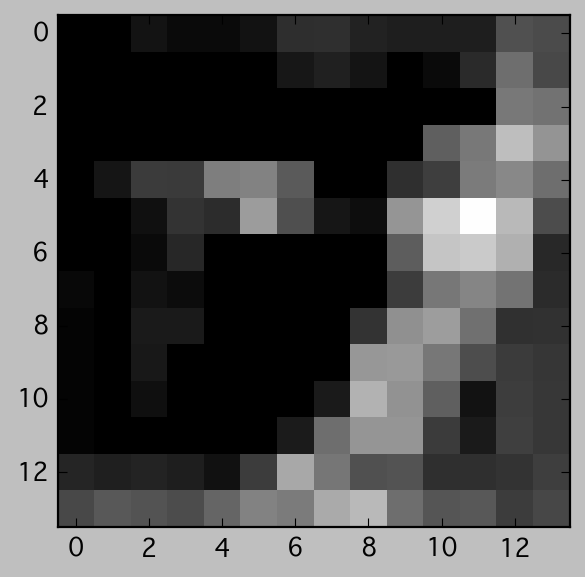

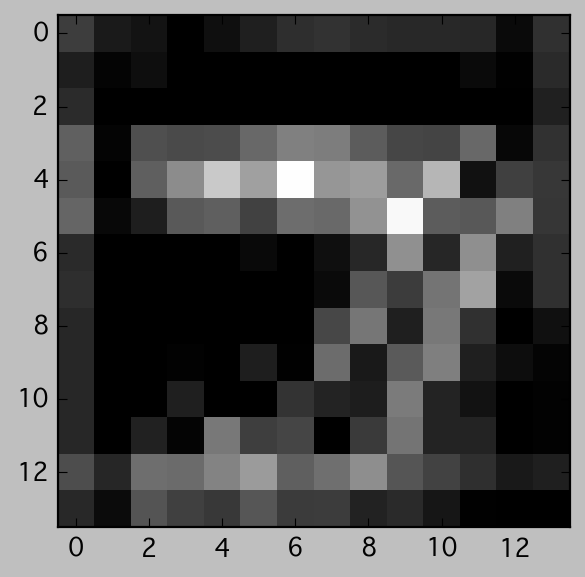

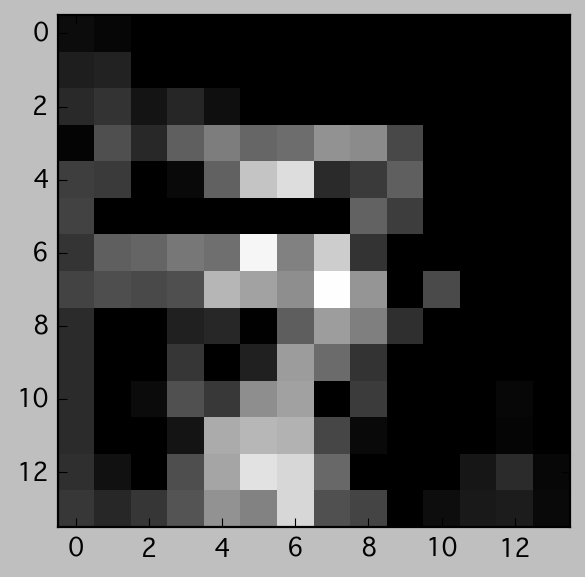

In [50]:
# ２つめの畳み込み層
for i in range(4):
    plt.figure()
    imshow(h_conv2.eval({x: test_images[0:1], y_: test_labels[0:1]})[0][:, :, i])

ここまで来ると、解釈まではよくわからない